✨🍰✨ Everything looks OK!
Channels:
 - rdkit
 - conda-forge
Platform: linux-64
Solving environment: - \ | / done


==> WARNING: A newer version of conda exists. <==
    current version: 24.11.3
    latest version: 25.1.1

Please update conda by running

    $ conda update -n base -c conda-forge conda



# All requested packages already installed.



Výstupní stream byl oříznut na posledních 5000 řádků.
[09:31:07] DEPRECATION WARNING: please use MorganGenerator
[09:31:07] DEPRECATION WARNING: please use MorganGenerator
[09:31:07] DEPRECATION WARNING: please use MorganGenerator
[09:31:07] DEPRECATION WARNING: please use MorganGenerator
[09:31:07] DEPRECATION WARNING: please use MorganGenerator
[09:31:07] DEPRECATION WARNING: please use MorganGenerator
[09:31:07] DEPRECATION WARNING: please use MorganGenerator
[09:31:07] DEPRECATION WARNING: please use MorganGenerator
[09:31:07] DEPRECATION WARNING: please use MorganGenerator
[09:31:07] DEPRECATION WARNING: please use MorganGenerator
[09:31:07] DEPRECATION WARNING: please use MorganGenerator
[09:31:07] DEPRECATION WARNING: please use MorganGenerator
[09:31:07] DEPRECATION WARNING: please use MorganGenerator
[09:31:07] DEPRECATION WARNING: please use MorganGenerator
[09:31:07] DEPRECATION WARNING: please use MorganGenerator
[09:31:07] DEPRECATION WARNING: please use MorganGenerator
[0

Training MSE: 0.3521
Validation MSE: 0.4826
Test MSE: 0.4479


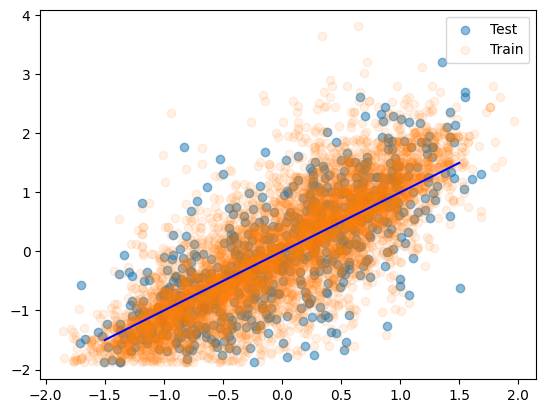

7.683040145997721


[09:31:27] DEPRECATION WARNING: please use MorganGenerator


In [6]:
!pip install -q condacolab
import condacolab
condacolab.install()
!conda install -c rdkit rdkit

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from rdkit import Chem, DataStructs
from rdkit.Chem import PandasTools, AllChem

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error


data = pd.read_csv("./dataset.csv")
PandasTools.AddMoleculeColumnToFrame(data, 'SMILES', 'Molecule')

def mol2fp(mol):
    fp = AllChem.GetHashedMorganFingerprint(mol, 2, nBits=4096)
    ar = np.zeros((1,), dtype=np.int8)
    DataStructs.ConvertToNumpyArray(fp, ar)
    return ar

data["FPs"] = data.Molecule.apply(mol2fp)
X = np.stack(data.FPs.values)
y = data.pXC50.values.reshape((-1,1))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.05, random_state=42)

scaler = StandardScaler()
y_train = scaler.fit_transform(y_train)
y_test = scaler.transform(y_test)
y_validation = scaler.transform(y_validation)

feature_select = VarianceThreshold(threshold=0.05)
X_train = feature_select.fit_transform(X_train)
X_validation = feature_select.transform(X_validation)
X_test = feature_select.transform(X_test)

svm_model = SVR(kernel='rbf', C=1.0, epsilon=0.1)
svm_model.fit(X_train, y_train.ravel())


y_pred_train = svm_model.predict(X_train)
y_pred_validation = svm_model.predict(X_validation)
y_pred_test = svm_model.predict(X_test)

train_mse = mean_squared_error(y_train, y_pred_train)
validation_mse = mean_squared_error(y_validation, y_pred_validation)
test_mse = mean_squared_error(y_test, y_pred_test)

print(f"Training MSE: {train_mse:.4f}")
print(f"Validation MSE: {validation_mse:.4f}")
print(f"Test MSE: {test_mse:.4f}")


plt.scatter(y_pred_test, y_test, alpha=0.5, label="Test")
plt.scatter(y_pred_train, y_train, alpha=0.1, label="Train")
plt.legend()
plt.plot([-1.5, 1.5], [-1.5, 1.5], c="b")
plt.show()


def predict_smiles(smiles):
    fp = mol2fp(Chem.MolFromSmiles(smiles)).reshape(1,-1)
    fp_filtered = feature_select.transform(fp)
    prediction = svm_model.predict(fp_filtered)
    pXC50 = scaler.inverse_transform(prediction.reshape(-1,1))
    return pXC50[0][0]

# prediction
print(predict_smiles('Cc1ccc2c(N3CCNCC3)cc(F)cc2n1'))

